<a href="https://colab.research.google.com/github/tarenkovia/Music_predict/blob/main/Music_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
#импортируем основные библиотеки для работы с данными
import matplotlib.pyplot as plt
import IPython.display as id
import soundfile as sf
from PIL import Image
import pandas as pd
import numpy as np
import librosa
import os
import pathlib
import csv

#импортируем метод разбиениея данных и нормализацию
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing

#импортируем Keras
import keras
from keras import layers
from keras.models import Sequential

#импортируем пакет для ошибок
import warnings
warnings.filterwarnings('ignore')

#импортируем гугл диск, чтобы с него подгружать данные
from google.colab import drive
drive.mount('/content/drive/')

#импортируем классификаторы для обучения
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

#импортируем классы для работы с моделью
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.initializers import glorot_uniform

#импортируем инструменты для работы с данными
from keras.utils import to_categorical

Mounted at /content/drive/


# **Пример работы некоторых функций для анализа аудиоданных**

Загрузка аудиоданных

In [ ]:
audio_data = '/content/drive/MyDrive/genres/Ludovico Einaudi - Experience.wav'
x , sr = librosa.load(audio_data)
print(type(x), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
print(x.shape, sr)

(662404,) 22050


Этот фрагмент возвращает звуковой временной ряд в качестве массива numpy с частотой дискретизации по умолчанию 22 кГц моно.

**Визуализация данного аудифайла**

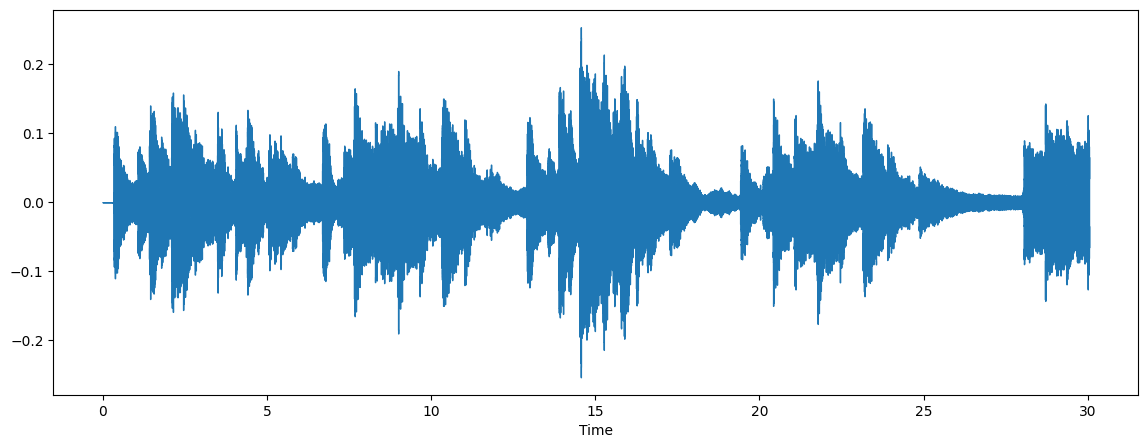

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

**Спектограмма**

Спектрограмма — это визуальный способ представления уровня или «громкости» сигнала во времени на различных частотах, присутствующих в форме волны. Обычно изображается в виде тепловой карты.

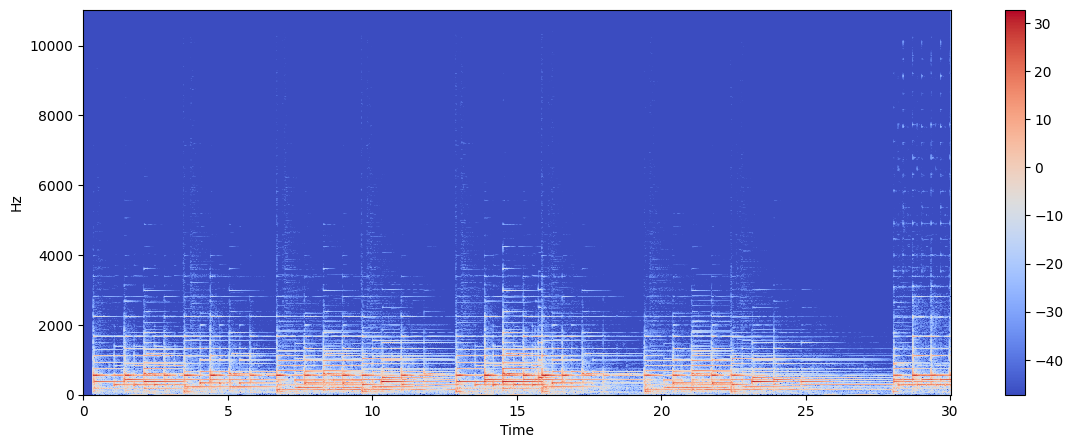

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

.stft() преобразует данные в кратковременное преобразование Фурье. С помощью STFT можно определить амплитуду различных частот, воспроизводимых в данный момент времени аудиосигнала. Для отображения спектрограммы используется .specshow.

На вертикальной оси показаны частоты (от 0 до 10 кГц), а на горизонтальной — время. Поскольку все действие происходит в нижней части спектра, мы можем преобразовать ось частот в логарифмическую.

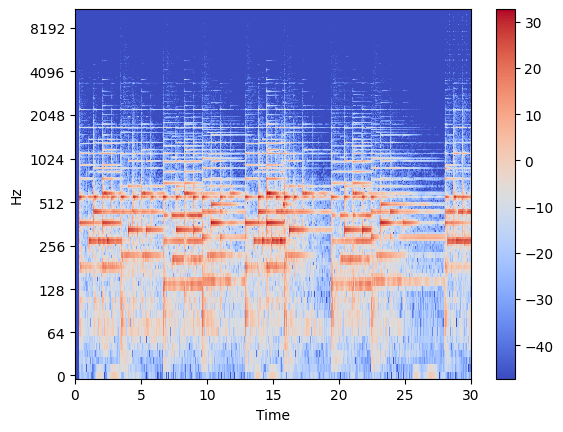

In [ ]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## **Спектральный центроид**




Указывает, на какой частоте сосредоточена энергия спектра или, другими словами, указывает, где расположен «центр масс» для звука. Схож со средневзвешенным значением.

In [ ]:
y, sr = librosa.load('/content/drive/MyDrive/genres/Ludovico Einaudi - Experience.wav')
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
cent

array([[   0.        ,    0.        ,    0.        , ...,  675.50496484,
         686.5862901 , 1167.24215772]])

In [ ]:
S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_centroid(S=S)

array([[   0.        ,    0.        ,    0.        , ...,  675.50496484,
         686.5862901 , 1167.24215772]])

In [ ]:
freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
librosa.feature.spectral_centroid(S=np.abs(D), freq=freqs)

array([[   0.        ,    0.        ,    0.        , ...,  675.23168803,
         686.63379526, 1167.25402111]])

[Text(0.5, 1.0, 'log Power spectrogram')]

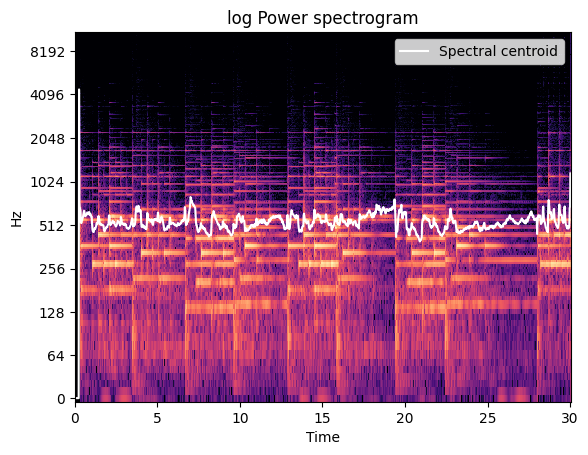

In [ ]:
import matplotlib.pyplot as plt
times = librosa.times_like(cent)
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),sr=sr,
                         y_axis='log', x_axis='time', fmax=sr/2)
ax.plot(times, cent.T, label='Spectral centroid', color='w')
ax.legend(loc='upper right')
ax.set(title='log Power spectrogram')

## **Спектральный спад**

Это мера формы сигнала, представляющая собой частоту, в которой высокие частоты снижаются до 0. Чтобы получить ее, нужно рассчитать долю элементов в спектре мощности, где 85% ее мощности находится на более низких частотах.

In [ ]:
# Приблизительные максимальные частоты при roll_percent=0,85 (по умолчанию)
librosa.feature.spectral_rolloff(y=y, sr=sr)

array([[   0.        ,    0.        ,    0.        , ...,  925.92773438,
         850.56152344, 1658.05664062]])

In [ ]:
# Приблизительные максимальные частоты при roll_percent=0,99
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.99)
rolloff

array([[    0.        ,     0.        ,     0.        , ...,
         6212.32910156,  6513.79394531, 10045.23925781]])

In [ ]:
# Приблизительные минимальные частоты с roll_percent=0,01
rolloff_min = librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.01)
rolloff_min

array([[ 0.        ,  0.        ,  0.        , ..., 64.59960938,
        86.1328125 , 64.59960938]])

In [ ]:
S, phase = librosa.magphase(librosa.stft(y))
librosa.feature.spectral_rolloff(S=S, sr=sr)

array([[   0.        ,    0.        ,    0.        , ...,  925.92773438,
         850.56152344, 1658.05664062]])

In [ ]:
# С более высоким процентом отката:
librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)

array([[   0.        ,    0.        ,    0.        , ..., 1668.82324219,
        1679.58984375, 6180.02929688]])

[Text(0.5, 1.0, 'log Power spectrogram')]

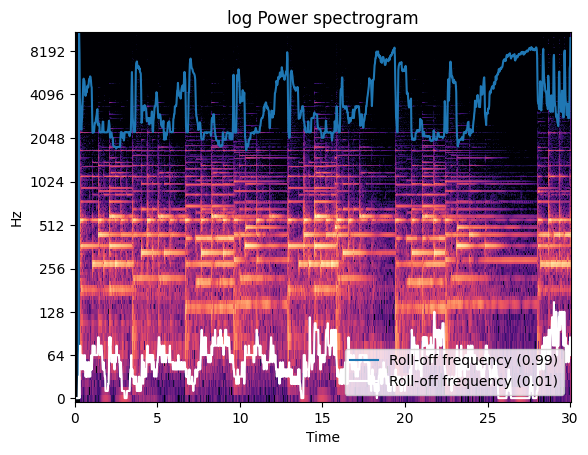

In [ ]:
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr,
                         y_axis='log', x_axis='time', fmax=sr/2)
ax.plot(librosa.times_like(rolloff), rolloff[0], label='Roll-off frequency (0.99)')
ax.plot(librosa.times_like(rolloff), rolloff_min[0], color='w',
        label='Roll-off frequency (0.01)')
ax.legend(loc='lower right')
ax.set(title='log Power spectrogram')

## **Спектральная ширина**

Спектральная ширина определяется как ширина полосы света на половине максимальной точки (или полная ширина на половине максимума [FWHM]) и представлена двумя вертикальными красными линиями и λSB на оси длин волн.

In [ ]:
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spec_bw

array([[   0.        ,    0.        ,    0.        , ...,  934.38054259,
         978.20549208, 1970.17174602]])

In [ ]:
S, phase = librosa.magphase(librosa.stft(y=y))
librosa.feature.spectral_bandwidth(S=S)

array([[   0.        ,    0.        ,    0.        , ...,  934.38054259,
         978.20549208, 1970.17174602]])

In [ ]:
freqs, times, D = librosa.reassigned_spectrogram(y, fill_nan=True)
librosa.feature.spectral_bandwidth(S=np.abs(D), freq=freqs)

array([[   0.        ,    0.        ,    0.        , ...,  934.38043266,
         978.14742951, 1970.14410554]])

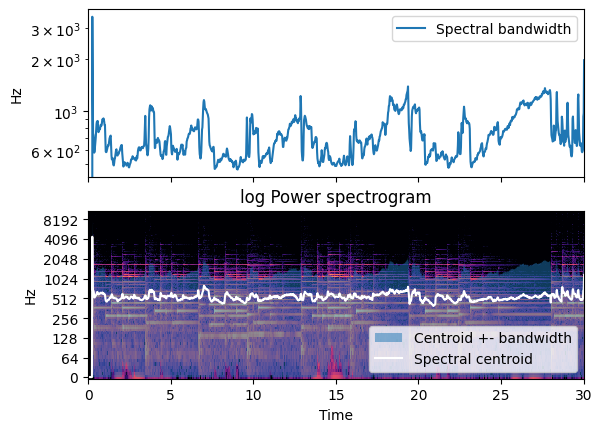

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S=S)
ax[0].semilogy(times, spec_bw[0], label='Spectral bandwidth')
ax[0].set(ylabel='Hz', xticks=[], xlim=[times.min(), times.max()])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
ax[1].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                np.minimum(centroid[0] + spec_bw[0], sr/2),
                alpha=0.5, label='Centroid +- bandwidth')
ax[1].plot(times, centroid[0], label='Spectral centroid', color='w')
ax[1].legend(loc='lower right')

## **Скорость пересечения нуля**

Простой способ измерения гладкости сигнала - вычисление числа пересечений нуля в пределах сегмента этого сигнала. Голосовой сигнал колеблется медленно. Например, сигнал 100 Гц будет пересекать ноль 100 раз в секунду, тогда как "немой" фрикативный сигнал может иметь 3000 пересечений нуля в секунду.

Более высокие значения наблюдаются в таких высоко ударных звуках, как в металле и роке. Теперь визуализируем этот процесс и рассмотрим вычисление скорости пересечения нуля.

In [ ]:
z = librosa.zero_crossings(y)
# Stack y against the zero-crossing indicator
librosa.util.stack([y, z], axis=-1)

array([[0.        , 1.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.03166853, 0.        ],
       [0.03941325, 0.        ],
       [0.05380144, 0.        ]], dtype=float32)

In [ ]:
# Find the indices of zero-crossings
np.nonzero(z)

(array([     0,   6640,   6646, ..., 662358, 662376, 662399]),)

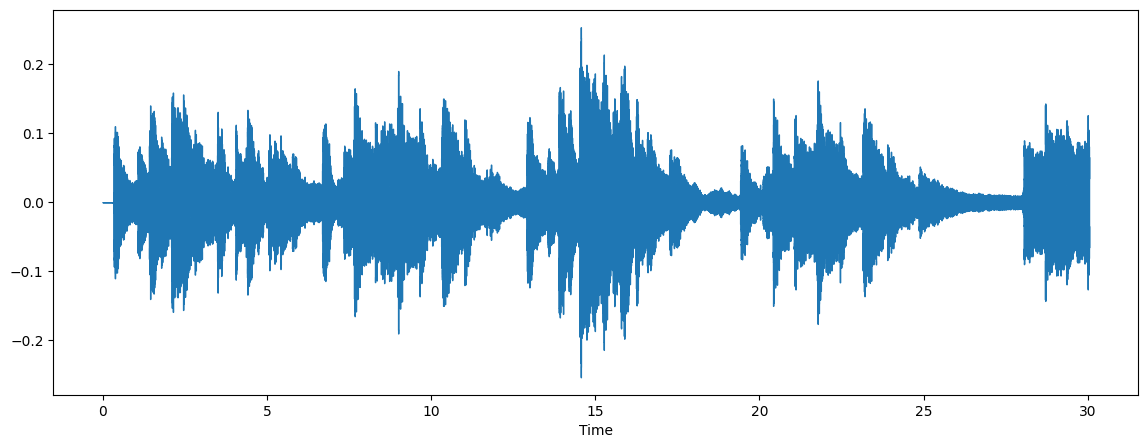

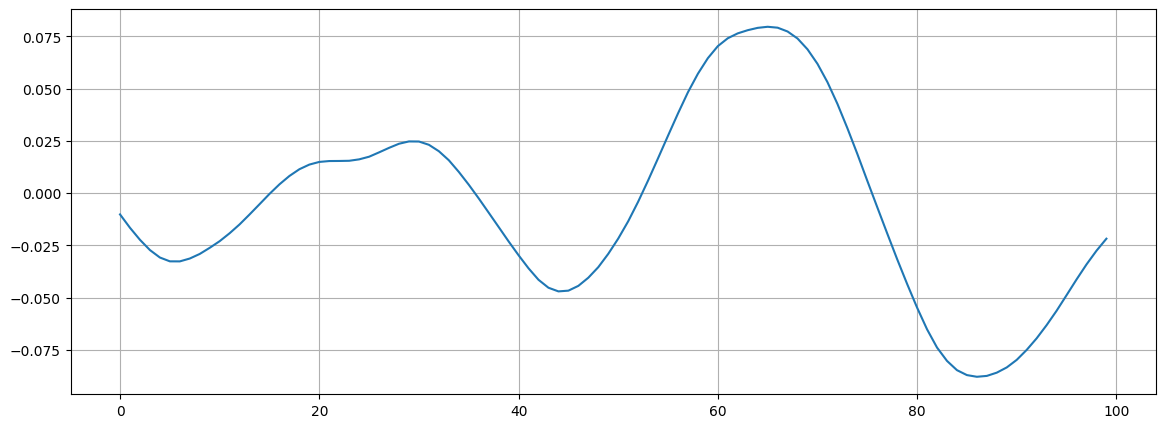

In [ ]:
# Построение графика сигнала:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y=y, sr=sr)
# Увеличение масштаба:
n0 = 9000
n1 = 9100
plt.figure(figsize=(14, 5))
plt.plot(x[n0:n1])
plt.grid()

Здесь 4 пересечения нуля. Проверим это с помощью Librosa.

In [ ]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

4


## **Мел-частотные кепстральные коэффициенты (MFCC)**

Представляют собой небольшой набор признаков (обычно около 10–20), которые кратко описывают общую форму спектральной огибающей. Они моделируют характеристики человеческого голоса.

In [ ]:
librosa.feature.mfcc(y=y, sr=sr)

array([[-6.7902545e+02, -6.7902545e+02, -6.7902545e+02, ...,
        -3.9351627e+02, -3.7127826e+02, -3.1388690e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.1249774e+02,  2.0649741e+02,  1.4529335e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.8268227e+01,  1.7417091e+01,  3.0073238e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -7.3474073e+00, -6.9855270e+00, -2.5437636e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         6.1917858e+00,  4.2095718e+00,  9.6695626e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.1005487e+01,  1.0828226e+01, -2.0167148e-01]], dtype=float32)

In [ ]:
librosa.feature.mfcc(y=y, sr=sr, hop_length=1024, htk=True)

array([[-689.6466   , -689.6466   , -689.6466   , ..., -486.05035  ,
        -468.781    , -379.01245  ],
       [   0.       ,    0.       ,    0.       , ...,  190.18753  ,
         208.35689  ,  209.75189  ],
       [   0.       ,    0.       ,    0.       , ...,   43.67965  ,
          40.01651  ,   16.270151 ],
       ...,
       [   0.       ,    0.       ,    0.       , ...,   -1.9673343,
          -3.6862493,    5.87314  ],
       [   0.       ,    0.       ,    0.       , ...,    1.4729345,
           3.0767787,   -4.7030854],
       [   0.       ,    0.       ,    0.       , ...,    6.93322  ,
           7.859832 ,    7.0814767]], dtype=float32)

In [ ]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.feature.mfcc(S=librosa.power_to_db(S))

array([[-6.8068024e+02, -6.8068024e+02, -6.8068024e+02, ...,
        -3.6749039e+02, -3.4537253e+02, -2.9731445e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         2.0380508e+02,  1.9707611e+02,  1.4166626e+02],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.1194708e+00,  3.7574229e+00,  2.2918655e+01],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.3105480e+01,  1.2017443e+01,  3.8353091e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         1.0634392e+00, -3.8592601e+00, -6.1099586e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -6.2773156e+00, -7.7491441e+00, -3.3383758e+00]], dtype=float32)

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

[Text(0.5, 1.0, 'MFCC')]

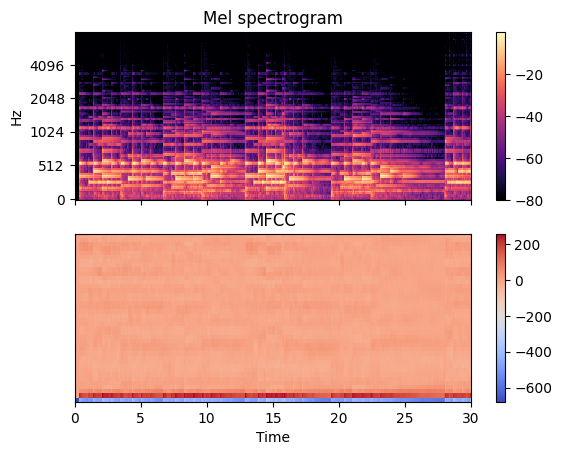

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

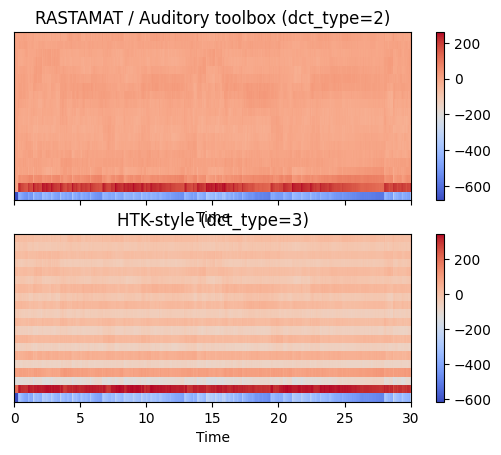

In [ ]:
m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2)
m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3)
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
img1 = librosa.display.specshow(m_slaney, x_axis='time', ax=ax[0])
ax[0].set(title='RASTAMAT / Auditory toolbox (dct_type=2)')
fig.colorbar(img, ax=[ax[0]])
img2 = librosa.display.specshow(m_htk, x_axis='time', ax=ax[1])
ax[1].set(title='HTK-style (dct_type=3)')
fig.colorbar(img2, ax=[ax[1]])

## **Цветность**

Признак или вектор цветности обычно представлен вектором признаков из 12 элементов, в котором указано количество энергии каждого высотного класса {C, C#, D, D#, E, …, B} в сигнале. Используется для описания меры сходства между музыкальными произведениями.

In [ ]:
librosa.feature.chroma_stft(y=y, sr=sr)

array([[0.        , 0.        , 0.        , ..., 0.18108101, 0.1377648 ,
        0.14706068],
       [0.        , 0.        , 0.        , ..., 0.48136058, 0.4184066 ,
        0.48984784],
       [0.        , 0.        , 0.        , ..., 0.13586088, 0.10114191,
        0.12714241],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.20037006, 0.22495674,
        0.21969086],
       [0.        , 0.        , 0.        , ..., 0.01698836, 0.0188921 ,
        0.01641914]], dtype=float32)

In [ ]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
chroma

array([[0.        , 0.        , 0.        , ..., 0.5320784 , 0.45123726,
        0.4254439 ],
       [0.        , 0.        , 0.        , ..., 0.987526  , 0.95929646,
        0.9772012 ],
       [0.        , 0.        , 0.        , ..., 0.51707506, 0.40778238,
        0.45181143],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.39968422, 0.414502  ,
        0.4143648 ],
       [0.        , 0.        , 0.        , ..., 0.21301234, 0.21269065,
        0.2102465 ]], dtype=float32)

In [ ]:
S = np.abs(librosa.stft(y, n_fft=4096))**2
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
chroma

array([[0.        , 0.        , 0.        , ..., 0.10445563, 0.1085986 ,
        0.11273308],
       [0.        , 0.        , 0.        , ..., 0.53753227, 0.49532685,
        0.4731094 ],
       [0.        , 0.        , 0.        , ..., 0.09526885, 0.08586596,
        0.09650869],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.13939443, 0.1460098 ,
        0.17463219],
       [0.        , 0.        , 0.        , ..., 0.00216001, 0.00644683,
        0.01379987]], dtype=float32)

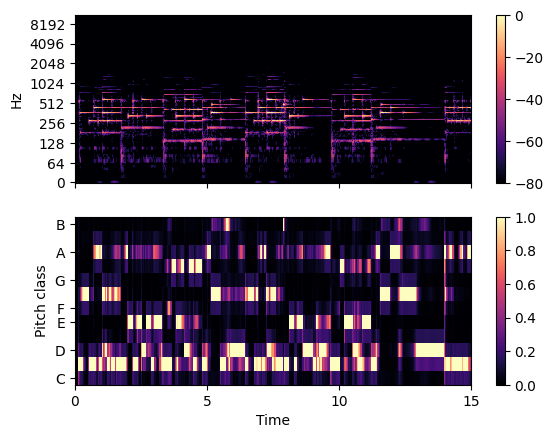

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), sr=sr,
                               y_axis='log', x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].label_outer()
img = librosa.display.specshow(chroma, sr=sr, y_axis='chroma', x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])

# **Подгрузка и обработка аудиоданных**

Для начала необходимо распаковать данные, чтобы с ними работать. Из диска загружать их быстрее всего в формате архива.

In [ ]:
! unzip '/content/drive/MyDrive/3 курс/Курсач/genres_original (2).zip'
! unzip '/content/drive/MyDrive/3 курс/Курсач/images_original.zip'

Archive:  /content/drive/MyDrive/3 курс/Курсач/genres_original (2).zip
   creating: genres_original/blues/
  inflating: genres_original/blues/blues.00000.wav  
  inflating: genres_original/blues/blues.00001.wav  
  inflating: genres_original/blues/blues.00002.wav  
  inflating: genres_original/blues/blues.00003.wav  
  inflating: genres_original/blues/blues.00004.wav  
  inflating: genres_original/blues/blues.00005.wav  
  inflating: genres_original/blues/blues.00006.wav  
  inflating: genres_original/blues/blues.00007.wav  
  inflating: genres_original/blues/blues.00008.wav  
  inflating: genres_original/blues/blues.00009.wav  
  inflating: genres_original/blues/blues.00010.wav  
  inflating: genres_original/blues/blues.00011.wav  
  inflating: genres_original/blues/blues.00012.wav  
  inflating: genres_original/blues/blues.00013.wav  
  inflating: genres_original/blues/blues.00014.wav  
  inflating: genres_original/blues/blues.00015.wav  
  inflating: genres_original/blues/blues.0001

Далее мы создаем спектрограммы каждого файла и сохраняем их.

In [ ]:
cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'/content/images_original/{g}').mkdir(parents=True, exist_ok=True)
    for filename in os.listdir(f'/content/genres_original/{g}'):
        songname = f'/content/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=5)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'/content/images_original/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()

<Figure size 800x800 with 0 Axes>

Далее подготавливаем среду для создания csv файла: создаем заголовки столцов, высчитываем метрики из аудиоданных.

In [ ]:
# создаем заголовки для csv файла
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate tempo spec_cont flatness'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

# далее создаем и открываем файл для записи данных в него
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
# запускаем цикл в котором будем считать наши метрики и записывать их
for g in genres:
    for filename in os.listdir(f'/content/genres_original/{g}'):
        songname = f'/content/genres_original/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        S = np.abs(librosa.stft(y))
        spec_cont = librosa.feature.spectral_contrast(S=S, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=y)
        tempo = librosa.feature.tempo(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(tempo)} {np.mean(spec_cont)} {np.mean(flatness)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

Далее считываем наш файл и смотрим, что в нем хранится

In [ ]:
data = pd.read_csv('dataset.csv')
data.head()

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,tempo,spec_cont,flatness,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,blues.00095.wav,0.369967,0.187063,1388.445487,1772.842265,2754.616677,0.057147,135.999178,22.863342,0.001597,...,1.613636,-6.629041,4.952462,-1.633869,0.953964,-4.841610,-5.970589,-2.786720,-6.492816,blues
1,blues.00096.wav,0.260613,0.051328,1132.518423,1582.765488,2066.245839,0.048314,123.046875,23.630066,0.000927,...,2.063028,-11.438629,-9.510527,-15.186693,-9.362388,-5.665494,1.562117,0.897125,-7.956727,blues
2,blues.00023.wav,0.280721,0.101915,1210.457126,1498.054609,2522.543080,0.052483,95.703125,21.828066,0.000550,...,-9.429529,-10.923911,3.562557,4.137706,0.095544,-2.972545,-1.378875,7.541176,-3.037463,blues
3,blues.00089.wav,0.348693,0.052772,798.568445,1284.947480,1455.816197,0.025640,107.666016,20.903558,0.000767,...,-2.353006,3.193639,0.705300,-3.092132,-2.110178,-2.212081,-4.576663,-4.726689,0.059275,blues
4,blues.00032.wav,0.276268,0.101157,1309.664697,1883.062612,2765.658276,0.039393,123.046875,26.985884,0.001231,...,-6.650616,-11.713253,-2.938389,-7.372581,-15.697483,-10.974154,-10.889544,-18.505476,-19.103352,blues


Производим обработку данных и подготовляем данные к обучению

In [ ]:
# Удаление ненужных столбцов
#data = data.drop(['filename'],axis=1)


# Создание меток
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

# Масштабирование столбцов признаков
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))


# Разделение данных на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Модели и их обучение**

## **KNN**

In [ ]:
# обучаем нашу модель и смотрим на то, как хорошо сработал классификатор
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
knn_score = clf_knn.score(X_test, y_test)
knn_score

0.68

In [ ]:
#тренировочный набор
y_pred_knn = clf_knn.predict(X_train)
print(classification_report(y_train, y_pred_knn, target_names = genres))

              precision    recall  f1-score   support

       blues       0.76      0.86      0.80        79
   classical       0.81      0.95      0.87        77
     country       0.59      0.82      0.69        85
       disco       0.63      0.76      0.69        79
      hiphop       0.76      0.67      0.72        86
        jazz       0.84      0.63      0.72        81
       metal       0.90      0.80      0.85        76
         pop       0.73      0.78      0.76        78
      reggae       0.83      0.63      0.71        83
        rock       0.71      0.51      0.60        76

    accuracy                           0.74       800
   macro avg       0.76      0.74      0.74       800
weighted avg       0.75      0.74      0.74       800



## **DecisionTree**

In [ ]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
dt_score = clf_dt.score(X_test, y_test)
dt_score

0.525

In [ ]:
y_pred_dt = clf_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt, target_names = genres))

              precision    recall  f1-score   support

       blues       0.50      0.57      0.53        21
   classical       0.88      0.65      0.75        23
     country       0.30      0.60      0.40        15
       disco       0.56      0.43      0.49        21
      hiphop       0.43      0.64      0.51        14
        jazz       0.61      0.58      0.59        19
       metal       0.90      0.79      0.84        24
         pop       0.73      0.50      0.59        22
      reggae       0.46      0.35      0.40        17
        rock       0.16      0.17      0.16        24

    accuracy                           0.53       200
   macro avg       0.55      0.53      0.53       200
weighted avg       0.57      0.53      0.54       200



## **RandomForest**

In [ ]:
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
rf_score = clf_rf.score(X_test, y_test)
rf_score

0.64

In [ ]:
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names = genres))

              precision    recall  f1-score   support

       blues       0.74      0.81      0.77        21
   classical       1.00      0.74      0.85        23
     country       0.39      0.60      0.47        15
       disco       0.54      0.62      0.58        21
      hiphop       0.47      0.57      0.52        14
        jazz       0.64      0.84      0.73        19
       metal       0.95      0.83      0.89        24
         pop       0.62      0.59      0.60        22
      reggae       0.53      0.47      0.50        17
        rock       0.50      0.29      0.37        24

    accuracy                           0.64       200
   macro avg       0.64      0.64      0.63       200
weighted avg       0.66      0.64      0.64       200



## **AdaBoost**

In [ ]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada.fit(X_train, y_train)
ada_score = clf_ada.score(X_test, y_test)
ada_score

0.36

In [ ]:
y_pred_ada = clf_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada, target_names = genres))

              precision    recall  f1-score   support

       blues       0.00      0.00      0.00        21
   classical       0.59      0.74      0.65        23
     country       0.00      0.00      0.00        15
       disco       0.00      0.00      0.00        21
      hiphop       0.00      0.00      0.00        14
        jazz       0.45      0.53      0.49        19
       metal       0.24      1.00      0.38        24
         pop       0.43      0.91      0.58        22
      reggae       1.00      0.06      0.11        17
        rock       0.00      0.00      0.00        24

    accuracy                           0.36       200
   macro avg       0.27      0.32      0.22       200
weighted avg       0.27      0.36      0.24       200



## **GradientBoosting**

In [ ]:
clf_grad = GradientBoostingClassifier().fit(X_train, y_train)
grad_score = clf_grad.score(X_test, y_test)
grad_score

0.62

In [ ]:
y_pred_grad = clf_grad.predict(X_test)
print(classification_report(y_test, y_pred_grad, target_names = genres))

              precision    recall  f1-score   support

       blues       0.65      0.71      0.68        21
   classical       0.95      0.83      0.88        23
     country       0.42      0.67      0.51        15
       disco       0.52      0.57      0.55        21
      hiphop       0.59      0.71      0.65        14
        jazz       0.63      0.63      0.63        19
       metal       0.95      0.75      0.84        24
         pop       0.71      0.55      0.62        22
      reggae       0.53      0.53      0.53        17
        rock       0.33      0.29      0.31        24

    accuracy                           0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.64      0.62      0.62       200



## **HistGradientBoosting**

In [ ]:
clf_hgrad = HistGradientBoostingClassifier().fit(X_train, y_train)
hgrad_score = clf_hgrad.score(X_test, y_test)
hgrad_score

0.68

In [ ]:
y_pred_hgrad = clf_hgrad.predict(X_test)
print(classification_report(y_test, y_pred_hgrad, target_names = genres))

              precision    recall  f1-score   support

       blues       0.73      0.90      0.81        21
   classical       0.95      0.83      0.88        23
     country       0.48      0.67      0.56        15
       disco       0.69      0.43      0.53        21
      hiphop       0.62      0.71      0.67        14
        jazz       0.62      0.79      0.70        19
       metal       0.95      0.88      0.91        24
         pop       0.78      0.64      0.70        22
      reggae       0.48      0.65      0.55        17
        rock       0.47      0.33      0.39        24

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.69      0.68      0.68       200



## **SVC**

In [ ]:
clf_svc = make_pipeline(SVC(gamma='auto'))
clf_svc.fit(X_train, y_train)
svc_score = clf_svc.score(X_test, y_test)
svc_score

0.695

In [ ]:
y_pred_svc = clf_svc.predict(X_test)
print(classification_report(y_test, y_pred_svc, target_names = genres))

              precision    recall  f1-score   support

       blues       0.78      0.86      0.82        21
   classical       0.95      0.87      0.91        23
     country       0.50      0.67      0.57        15
       disco       0.54      0.62      0.58        21
      hiphop       0.67      0.71      0.69        14
        jazz       0.75      0.79      0.77        19
       metal       0.79      0.92      0.85        24
         pop       0.78      0.64      0.70        22
      reggae       0.67      0.47      0.55        17
        rock       0.47      0.38      0.42        24

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.70      0.69      0.69       200



Как видно по оценкам обучения, классификаторы справились не очень хорошо, поэтому перейдем к нейронной сети

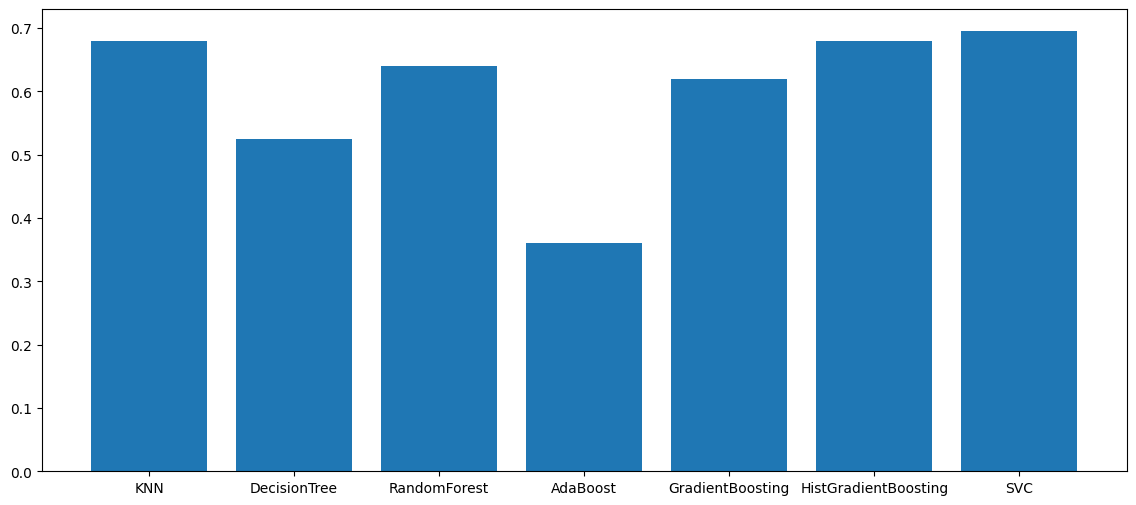

In [ ]:
index = ['KNN','DecisionTree', 'RandomForest','AdaBoost', 'GradientBoosting', 'HistGradientBoosting','SVC']
values = [knn_score, dt_score, rf_score, ada_score, grad_score, hgrad_score, svc_score ]
plt.figure(figsize=(14, 6))
plt.bar(index,values)
plt.show()

# **Нейронная сеть**

Создаем и настраиваем модель нашей нейронной сети: 

оптимизатор - Adam, 

функция потерь - categorical_crossentropy, 

метрика - accuracy

In [ ]:
# создаем экземпляр нашей модели
model = Sequential()

# добавляем слои в нашеу сеть, уменьшая количество нейронов на каждый слой
# при это будем так же дропать некоторую часть нейронов, для того, чтобы модель лучше обучалась
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3, name='1'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.3, name='2'))
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.3, name='3'))
model.add(layers.Dense(10, activation='softmax'))

# настраиваем сеть для более точной работы
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# необходимое преобразование наших данных для дальнейшего обучения
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
# обучаем нашу сеть
classifier = model.fit(X_train,
                    y_train,
                    epochs=80,
                    batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/80
5/5 [==============================] - 1s 61ms/step - loss: 2.2550 - accuracy: 0.1688 - val_loss: 2.0167 - val_accuracy: 0.3313
Epoch 2/80
5/5 [==============================] - 0s 19ms/step - loss: 2.0737 - accuracy: 0.2812 - val_loss: 1.8794 - val_accuracy: 0.3500
Epoch 3/80
5/5 [==============================] - 0s 19ms/step - loss: 1.9592 - accuracy: 0.3016 - val_loss: 1.7872 - val_accuracy: 0.3688
Epoch 4/80
5/5 [==============================] - 0s 16ms/step - loss: 1.8328 - accuracy: 0.3328 - val_loss: 1.7106 - val_accuracy: 0.3812
Epoch 5/80
5/5 [==============================] - 0s 14ms/step - loss: 1.7544 - accuracy: 0.3531 - val_loss: 1.6323 - val_accuracy: 0.4125
Epoch 6/80
5/5 [==============================] - 0s 15ms/step - loss: 1.6903 - accuracy: 0.3766 - val_loss: 1.5625 - val_accuracy: 0.4375
Epoch 7/80
5/5 [==============================] - 0s 18ms/step - loss: 1.6266 - accuracy: 0.4141 - val_loss: 1.4961 - val_accuracy: 0.4688
Epoch 8/80
5/5 [===========

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

7/7 [==============================] - 0s 3ms/step - loss: 1.2815 - accuracy: 0.6850
Test accuracy: 0.6850000023841858


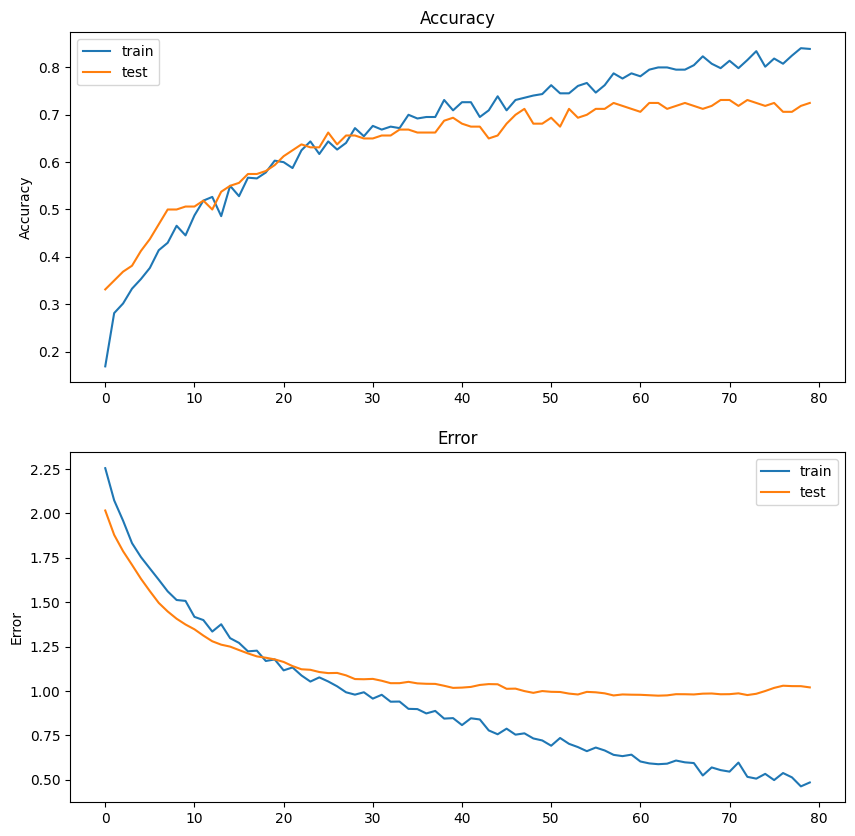

In [ ]:
# визуализируем результат
fig, axs = plt.subplots(2,figsize=(10,10))

# accuracy
axs[0].plot(classifier.history["accuracy"], label="train")
axs[0].plot(classifier.history["val_accuracy"], label="test")	
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].set_title("Accuracy")
	
# Error
axs[1].plot(classifier.history["loss"], label="train")
axs[1].plot(classifier.history["val_loss"], label="test")	
axs[1].set_ylabel("Error")
axs[1].legend()
axs[1].set_title("Error")
	
plt.show()

# **Работа с нашими данными**

Для начала сделаем две основные функции: первая будет обрабатывать аудиофайл, вторая обучать и предсказывать

In [ ]:
header = 'filename chroma_stft_mean rms_mean spectral_centroid_mean spectral_bandwidth_mean rolloff_mean zero_crossing_rate_mean tempo spec_cont flatness'
def audioProcessing(audio_data, filename, header, lable):
  # делаем спектограмму и сохраняем её
  cmap = plt.get_cmap('inferno')
  plt.figure(figsize=(8,8))
  pathlib.Path(f'/content/drive/MyDrive/img_data').mkdir(parents=True, exist_ok=True)
  filename = f'{filename}'
  y, sr = librosa.load(audio_data, mono=True, duration=5)
  plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
  plt.axis('off');
  plt.savefig(f'/content/drive/MyDrive/img_data/{filename[:-3].replace(".", "")}.png')
  plt.clf()

  # подготавливаем заголовки для файла и сам файл
  for i in range(1, 21):
    header += f' mfcc_mean{i}'
  header += ' label'
  header = header.split()

  file = open('myData.csv', 'w', newline='')
  with file:
    writer = csv.writer(file)
    writer.writerow(header)

  # высчитываем и записываем метрики
  y, sr = librosa.load(audio_data)
  S = np.abs(librosa.stft(y))
  spec_cont = librosa.feature.spectral_contrast(S=S, sr=sr)
  flatness = librosa.feature.spectral_flatness(y=y)
  tempo = librosa.feature.tempo(y=y, sr=sr)
  rms = librosa.feature.rms(y=y)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  # to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(tempo)} {np.mean(spec_cont)} {np.mean(flatness)}'    
  # for e in mfcc:
  #   to_append += f' {np.mean(e)}'
  # to_append += f' {lable}'
  to_append = ' '.join([f'{filename} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)} {np.mean(tempo)} {np.mean(spec_cont)} {np.mean(flatness)}'] + [f'{np.mean(e)}' for e in mfcc] + [f'{lable}'])
  file = open('myData.csv', 'a', newline='')
  with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())

def predValuesAndVisualization(data):
  # Удаление ненужных столбцов
  data = data.drop(['filename'],axis=1)

  # Создание меток
  y = encoder.transform(genre_list)

  # Масштабирование столбцов признаков
  X = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))

  # делаем предсказание и выводим вероятности пренадлежности классов
  predictions = model.predict(X)
  for i in range(len(X)):
	  print("X=%s, Predicted=%s" % (X[i], predictions[i]))

  # визулизируем предсказанные значения
  fig1, ax1 = plt.subplots()
  ax1.pie(predictions.flatten(), labels=genres)
  ax1.axis('equal')
  ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
  return plt.show()

## **Первый тест**

Далее создаем и заполняем необходимые переменные, вызываем первую функцию, смотрим на результат

In [ ]:
audio_data = '/content/drive/MyDrive/genres/Ludovico Einaudi - Experience.wav'
filename = 'Experience.wav'
lable = 'classical'
audioProcessing(audio_data, filename, header, lable)
data_exam1 = pd.read_csv('myData.csv')
data_exam1.head()

,filename,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,tempo,spec_cont,flatness,...,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,label
0,Experience.wav,0.21333,0.028043,541.292724,724.918353,672.96252,0.038192,92.285156,25.597063,0.009299,...,-6.997408,2.540179,6.995458,2.803475,-3.677583,-8.206897,-6.740342,-1.320656,-1.79039,classical


<Figure size 800x800 with 0 Axes>

И визуализируем полученные данные

1/1 [==============================] - 0s 72ms/step
X=[-2.02780878 -1.56639071 -2.3222616  -2.88557021 -2.47861866 -1.56710065
 -1.37454146  2.32632589 -0.42588932 -3.30259865  3.03876216  2.7846698
 -2.02017933  0.41981993 -1.41563837 -0.39866441 -2.29740226 -1.28096672
 -2.96668714 -0.96491151 -1.7091859   1.18916006  1.04108304  1.37065419
 -1.0552269  -0.9325081  -1.87274524  0.26835594 -0.18057868], Predicted=[2.0625652e-04 8.7030870e-01 1.4718181e-04 1.7016397e-08 1.1843251e-08
 1.2933394e-01 1.8912354e-09 5.3085977e-08 3.6811966e-06 4.9000512e-08]


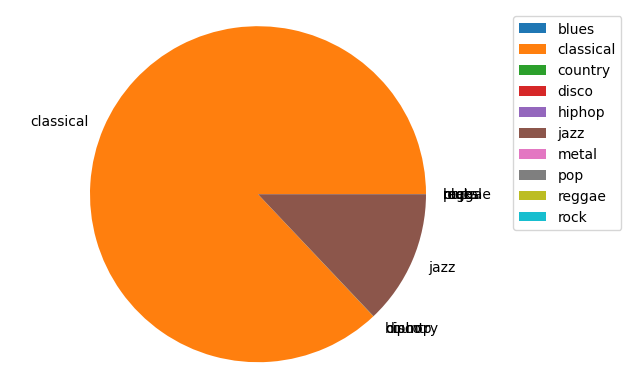

In [ ]:
predValuesAndVisualization(data_exam1)

## **Второй тест**

In [ ]:
audio_data = '/content/drive/MyDrive/genres/Korol_i_shut - lesnik.wav'
filename = 'Lesnik.wav'
lable = 'rock'
audioProcessing(audio_data, filename, header, lable)
data_exam2 = pd.read_csv('myData.csv')
data_exam2.head()

,filename,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,tempo,spec_cont,flatness,...,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,label
0,Lesnik.wav,0.450155,0.150205,2506.520431,2389.415373,5044.194498,0.128443,117.453835,21.659109,0.034695,...,6.348778,-5.240208,-1.414254,-7.692158,3.225987,-5.023369,-0.821683,-2.207468,-1.732611,rock


<Figure size 800x800 with 0 Axes>

1/1 [==============================] - 0s 26ms/step
X=[ 0.87441717  0.29527548  0.42465854  0.27860064  0.29939307  0.59184163
 -0.16695261  0.52188414  0.45397312  1.03511689 -0.47692131 -0.35120462
 -0.07020855  0.31503288 -0.80794957  0.59053761  0.49182273  0.80830048
 -0.99942115  0.97665684  0.27896547 -0.07200222 -0.63838442 -0.78408846
  0.45305873 -0.23264137 -0.34542903  0.03211136 -0.16551974], Predicted=[0.08933277 0.00454017 0.1983464  0.0454582  0.05006689 0.00683835
 0.4261011  0.00743949 0.00808543 0.16379113]


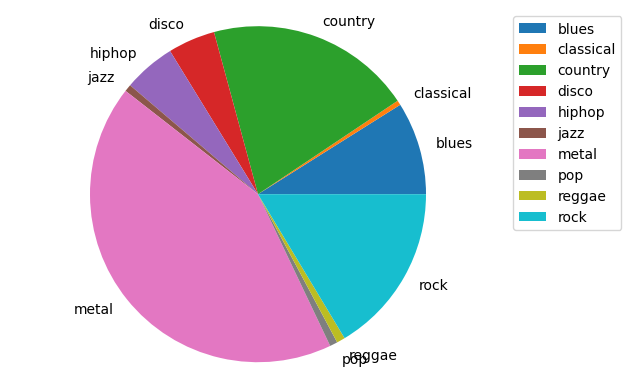

In [ ]:
predValuesAndVisualization(data_exam2)

## **Третий тест**

In [ ]:
audio_data = '/content/drive/MyDrive/genres/DVRST, Игорь Скляр - Komarovo.wav'
filename = 'Komarovo.wav'
lable = 'phonk'
audioProcessing(audio_data, filename, header, lable)
data_exam2 = pd.read_csv('myData.csv')
data_exam2.head()

,filename,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,tempo,spec_cont,flatness,...,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,label
0,Komarovo.wav,0.383371,0.224446,1319.911081,1870.199683,2643.159082,0.042211,151.999081,22.703413,0.004263,...,5.102243,3.320661,3.277208,3.344939,4.852803,-1.582045,5.823943,0.235574,3.729959,phonk


<Figure size 800x800 with 0 Axes>

1/1 [==============================] - 0s 24ms/step
X=[ 0.05598988  1.42664356 -1.23393864 -0.70841654 -1.22651647 -1.47095894
  1.49052228  1.00040309 -0.60036894  0.32624139  1.29084516  0.62364781
 -0.71737345  0.74898092 -0.57359848  1.01137206 -0.21159302  0.19356863
 -0.40441891  1.11838586  0.09327205  1.3156723   0.29852727  1.48181601
  0.808484    0.5238992   1.36948164  0.68293214  1.25820869], Predicted=[2.9781307e-03 8.2624964e-03 1.5796790e-01 8.6816697e-04 5.2553648e-04
 1.0103696e-01 7.1431245e-06 8.5387833e-04 7.2516114e-01 2.3386762e-03]


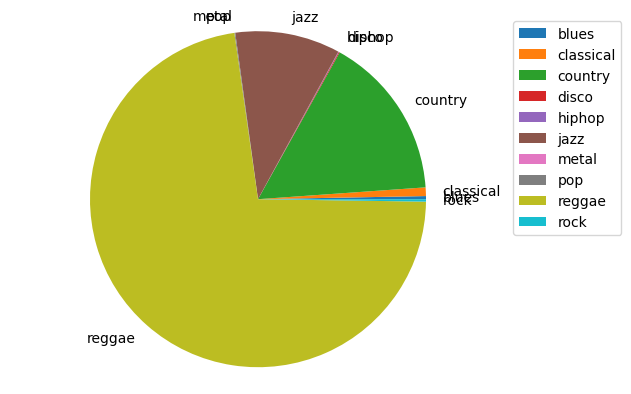

In [ ]:
predValuesAndVisualization(data_exam2)

4-й тест


In [ ]:
audio_data = '/content/drive/MyDrive/genres/The-Notorious-B.wav'
filename = 'Blues.wav'
lable = 'blues'
audioProcessing(audio_data, filename, header, lable)
data_exam4 = pd.read_csv('myData.csv')
data_exam4.head()

,filename,chroma_stft_mean,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean,tempo,spec_cont,flatness,...,mfcc_mean12,mfcc_mean13,mfcc_mean14,mfcc_mean15,mfcc_mean16,mfcc_mean17,mfcc_mean18,mfcc_mean19,mfcc_mean20,label
0,Blues.wav,0.4874,0.205047,2344.548407,2499.870832,5103.410807,0.081436,95.703125,22.004498,0.020861,...,9.097336,0.753149,4.160804,-2.755489,3.253714,-0.086998,1.790048,-1.019713,-0.306696,blues


<Figure size 800x800 with 0 Axes>

1/1 [==============================] - 0s 26ms/step
X=[ 1.33084271  1.13102753  0.19826024  0.48857395  0.3370263  -0.53263576
 -1.21054791  0.68014755 -0.02532828  0.32849136 -1.03452477  0.81897022
  0.75212807  0.94031065  1.2306956   1.20714647  0.61257315  1.28192095
  0.05552289  1.73602281  0.68841199  0.89949128  0.47498641  0.22940457
  0.45911637  0.85257029  0.32853077  0.34852645  0.20612142], Predicted=[1.4647625e-03 4.4384789e-05 1.9068528e-04 4.8905551e-03 8.3896852e-01
 1.0833042e-04 2.9081705e-03 4.3105974e-04 1.4708388e-01 3.9096540e-03]


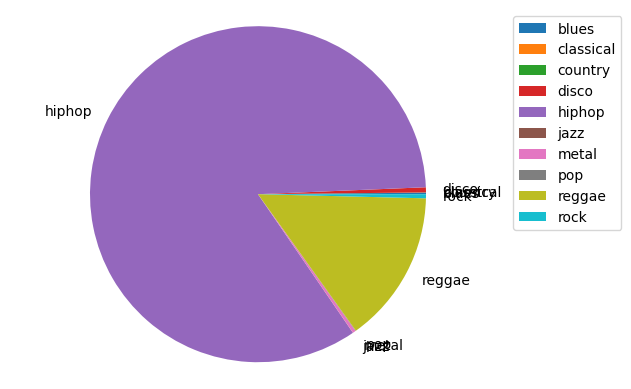

In [ ]:
predValuesAndVisualization(data_exam4)